In [1]:
import cv2
import os
from keras.applications.resnet50 import ResNet50
from keras.layers import Dense, BatchNormalization, Activation, Dropout, Flatten
from keras.models import Model
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedShuffleSplit
from collections import deque
from shutil import copyfile
import numpy as np
import ntpath


Using TensorFlow backend.


In [49]:
def read_video_file(file_path, save_folder, image_skip = 5, start_index = 0):
    vidcap = cv2.VideoCapture(file_path)
    fps = int(vidcap.get(cv2.CAP_PROP_FPS))
    success,image = vidcap.read()
    count = 0
    last_cought = -1
    while success:
        curr_sec_time = int(count / fps)
        if curr_sec_time >= last_cought:
            last_cought = curr_sec_time + image_skip
            cv2.imwrite(f"{save_folder}/{start_index}.jpg", image)
            start_index += 1
        success, image = vidcap.read()
        count += 1
    return start_index


In [15]:
indoor_images_folder = "c:/_Projects/indor_outdoor/videos/indoor_images"
outdoor_images_folder = "c:/_Projects/indor_outdoor/videos/outdoor_images"

In [51]:
start_index = 0
for root, dirs, files in os.walk("c:/_Projects/indor_outdoor/videos/indoor_videos"):
    for name in files:
        start_index = read_video_file(os.path.join(root, name), indoor_images_folder, start_index = start_index)

start_index = 0
for root, dirs, files in os.walk("c:/_Projects/indor_outdoor/videos/outdoor_videos"):
    for name in files:
        start_index = read_video_file(os.path.join(root, name), outdoor_images_folder, start_index = start_index)   

In [9]:
def make_square(image, square_size=224, inter = cv2.INTER_AREA):
    (h, w) = image.shape[:2]
    ratio = float(square_size)/max(h,w)
    h_r, w_r = int(ratio * h), int(w * ratio)
    delta_w = square_size - w_r
    delta_h = square_size - h_r
    top, bottom = delta_h//2, delta_h-(delta_h//2)
    left, right = delta_w//2, delta_w-(delta_w//2)

    color = [0, 0, 0]
    resized = cv2.resize(image, (w_r, h_r), interpolation = inter)
    resized = cv2.copyMakeBorder(resized, top, bottom, left, right, cv2.BORDER_CONSTANT, value=color)
    
    return resized

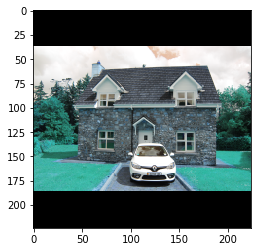

In [14]:
new_image = make_square(test_image)
plt.imshow(new_image)
plt.show()

In [7]:
final_root = "c:/_Projects/indor_outdoor/preprocessed"
final_indoor = f"{final_root}/indoor/"
final_outdoor = f"{final_root}/outdoor/"

In [25]:
name_index = 0
for root, dirs, files in os.walk(indoor_images_folder):
    for name in files:
        try:
            tmp_image = cv2.imread(os.path.join(root, name))
            resized_square_image = make_square(tmp_image)
            cv2.imwrite(os.path.join(final_indoor, f"{name_index:05}.jpg"), resized_square_image)
            name_index += 1
        except:
            print(f"Problem with file {name}")
        
name_index = 0
for root, dirs, files in os.walk(outdoor_images_folder):
    for name in files:
        try:
            tmp_image = cv2.imread(os.path.join(root, name))
            resized_square_image = make_square(tmp_image)
            cv2.imwrite(os.path.join(final_outdoor, f"{name_index:05}.jpg"), resized_square_image)
            name_index += 1
        except:
            print(f"Problem with file {name}")

In [75]:
X = deque()
y = deque()
for root, dirs, files in os.walk(final_root):
    for file in files:
        tmp_y = int(root.endswith("outdoor"))
        tmp_X = os.path.join(root, file)
        X.append(tmp_X)
        y.append(tmp_y)
        
X = np.array(X)
y = np.array(y)

In [76]:
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in sss.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

In [3]:
train_source_folder = "c:/_Projects/indor_outdoor/split/train"
test_source_folder = "c:/_Projects/indor_outdoor/split/valid"

In [89]:
def copy_to_tgt_folder(tgt_folder, in_X, in_y):
    for x, y in zip(in_X, in_y):
        if y == 0:
            dest_f = "indoor"
        else:
            dest_f = "outdoor"
        copyfile(x, os.path.join(tgt_folder, dest_f, ntpath.basename(x)))

copy_to_tgt_folder(train_source_folder, X_train, y_train)
copy_to_tgt_folder(test_source_folder, X_test, y_test)

In [8]:
generator_dimensions = (224, 224)

tmp_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=5,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

tmp_generator = tmp_datagen.flow_from_directory(
        final_root,
        target_size=generator_dimensions,
        batch_size=9,
        class_mode='binary') 

Found 4310 images belonging to 2 classes.


[1. 1. 1. 1. 1. 1. 0. 1. 0.]
(9, 224, 224, 3)


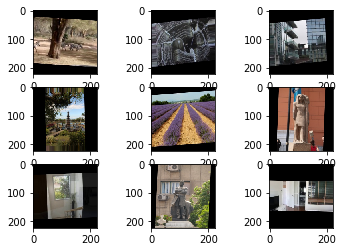

In [103]:
for images, classes in tmp_generator:
    print(classes)
    print(images.shape)
    for i, img in enumerate(images):
        ax = plt.subplot2grid((3, 3), (i // 3, i % 3))
        ax.imshow(img)
    break
plt.show()

In [2]:
base_model = ResNet50(input_shape=(224,224,3), include_top=False, weights='imagenet', pooling = 'max')

# add_model = Flatten()(base_model.output)
add_model = Dense(10)(base_model.output)
add_model = BatchNormalization()(add_model)
add_model = Activation("relu")(add_model)
add_model = Dense(10)(add_model)
add_model = BatchNormalization()(add_model)
add_model = Activation("relu")(add_model)
output_layer = Dense(1, activation="sigmoid")(add_model)

model = Model(inputs=[base_model.input], outputs=[output_layer])

# Stop training ResNet
for l in base_model.layers:
    model.get_layer(l.name).trainable = False

model.compile(optimizer='adam', loss='binary_crossentropy')
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

In [9]:
batch_size = 512

train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=5,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

train_generator = train_datagen.flow_from_directory(
        train_source_folder,
        target_size=generator_dimensions,
        batch_size=batch_size,
        class_mode='binary') 

test_datagen = ImageDataGenerator(
        rescale=1./255,
        horizontal_flip=True)

test_generator = test_datagen.flow_from_directory(
        test_source_folder,
        target_size=generator_dimensions,
        batch_size=batch_size,
        class_mode='binary') 

Found 3448 images belonging to 2 classes.
Found 862 images belonging to 2 classes.


In [10]:
train_steps_per_epoch = train_generator.samples // batch_size
test_steps_per_epoch = test_generator.samples // batch_size

print(f"Train steps: {train_steps_per_epoch}. Test steps: {test_steps_per_epoch}")

Train steps: 6. Test steps: 1


In [ ]:
model.fit_generator(
    train_generator,
    steps_per_epoch=train_steps_per_epoch,
    epochs=3, 
    verbose=1, 
    validation_data=test_generator,
    validation_steps=test_steps_per_epoch   
)

Epoch 1/3
